In [1]:
import sys
sys.path.append("../code/chain-diagnostics/")
import os

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.gridspec import GridSpec

import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

from chain_diagnostics import plot_chain_diagnostics
from getdist import MCSamples, plots

from cosmosis.runtime.config import Inifile
from cosmosis.runtime.pipeline import LikelihoodPipeline, Pipeline

%matplotlib inline

In [2]:
!head ../data/coupon-reproduction/hod_coupon.out.txt.join

/bin/bash: /home/pedro/miniconda3/envs/monografia/lib/libtinfo.so.6: no version information available (required by /bin/bash)
#hod_parameters--sigmam	hod_parameters--massmin	hod_parameters--alpha	hod_parameters--mass0	hod_parameters--mass1	post
#sampler=emcee
#n_varied=5
#module_0=consistent_parameters 1.0
#module_1=camb #name from ini file
#module_2=hmc #name from ini file
#walkers=50
#samples=1000
#nsteps=1
#random_start=False


/home/pedro/miniconda3/envs/monografia/lib/python3.7/site-packages/emcee/autocorr.py:41: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  acf = np.fft.ifft(f * np.conjugate(f), axis=axis)[m].real


Chain to short to estimate autocorrelation time for par  $\sigma_{\log\:M}$
Chain to short to estimate autocorrelation time for par  $\log\: M_{min}$
Chain to short to estimate autocorrelation time for par  $\alpha$
Chain to short to estimate autocorrelation time for par  $\log\: M_0$
Emcee integrated autocorrelation time for par  $\log\: M_1$  : 4.584073581774326


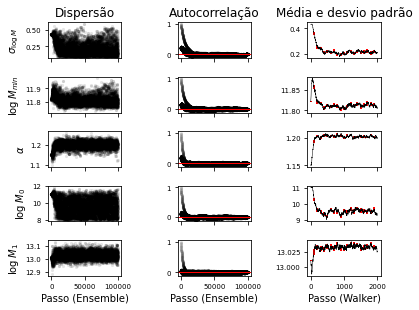

In [3]:
data_dir     = "../data/coupon-reproduction/"
plot_dir     = "../plots/coupon-reproduction/"
chain_fname  = os.path.join(data_dir, "hod_coupon.out.txt.join")
chain_data   = np.loadtxt(chain_fname)


fig      = plt.figure(figsize=(6.6, 4.4))
axs      = fig.subplots(5, 3, sharex="col")

names    = ["sigmam", "massmin", "alpha", "mass0", "mass1"]
labels   = [r"$\sigma_{\log\:M}$", r"$\log\: M_{min}$", r"$\alpha$", r"$\log\: M_0$", r"$\log\: M_1$"]
nwalkers = 50


fig, axs = plot_chain_diagnostics(samples=chain_data[:,:-1].T, labels=labels,
                                  nwalkers=nwalkers, fig=fig, axs=axs)

fig.tight_layout()

for ax in axs.flatten():
    ax.tick_params(axis='both', which='major', labelsize=7)
    ax.tick_params(axis='both', which='minor', labelsize=7)

plt.subplots_adjust(left=0.15, right=0.85, top=0.9, bottom=0.1)

fig.savefig(os.path.join(plot_dir, "chain_diagnostics_coupon_reproduction.pdf"), dpi=600)
fig.savefig(os.path.join(plot_dir, "chain_diagnostics_coupon_reproduction.png"), dpi=100)

In [4]:
coupon_values = {'sigmam':   0.43,
                 'massmin': 11.82,
                 'alpha':    1.15,
                 'mass0':   11.02,
                 'mass1':   13.01}

coupon_errs   = {'sigmam':  (0.11, 0.13),
                 'massmin': (0.06, 0.06),
                 'alpha':   (0.03, 0.03),
                 'mass0':   (0.38, 0.63),
                 'mass1':   (0.04, 0.04)}

coupon_grafico_values = {'sigmam':   0.461,
                         'massmin': 11.849,
                         'alpha':    1.129,
                         'mass0':    9.298,
                         'mass1':   12.985}

coupon_grafico_errs   = {'sigmam':  (0.107, 0.097),
                         'massmin': (0.175, 0.180),
                         'alpha':   (0.051, 0.052),
                         'mass0':   (1.473, 1.427),
                         'mass1':   (0.174, 0.180)}

bestfit = {
    "sigmam": 0.100398,
    "massmin": 11.8265,
    "alpha": 1.21162,
    "mass0": 9.77779,
    "mass1": 13.0355,
}

In [5]:
mc_samples = MCSamples(samples=chain_data[:,:-1], 
                       names=names, labels=map(lambda x: x.replace("$", ""), labels), 
                       loglikes=np.log(-chain_data[:,-1]), ignore_rows=0.5,
                       ranges={'sigmam':   (0.1, 0.6),
                               #'massmin': (11.6, 12.),
                               'massmin': (11., 15.),
                               'alpha':     (0.6, 2.0),
                               'mass0':     (8., 15.),
                               'mass1':   (12., 17.),
                              },
                        settings={"smooth_scale_2D": 0.4,
                                  "smooth_scale_1D": 0.4,
                                  "fine_bins_2D": 100,
                                  "fine_bins": 100},
                        label="Coupon Reproduction"
                      )

Removed 0.5 as burn in


In [6]:
def one_sigma_minmax(mc_samples, num):
    par = mc_samples.getMargeStats().parsWithNames(names[num])[0]
    try:
        return par.limits[0].lower, par.limits[0].upper
    except AttributeError:
        return np.nan, np.nan

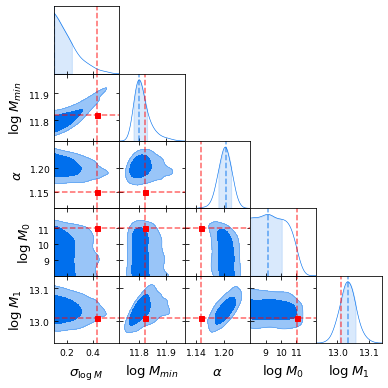

In [7]:
g = plots.getSubplotPlotter()
g.settings.alpha_filled_add     = 0.6
g.settings.fig_width_inch       = 5.5
g.settings.axes_fontsize        = 14
g.settings.axes_labelsize       = 18

g.triangle_plot([mc_samples,], filled=True,
                title_limit=0,
                contour_colors = [g.settings.solid_colors[0]],
               )

for i, key in enumerate(coupon_values.keys()):
    for j, other_key in enumerate(coupon_values.keys()):
        if j > i:
            continue
        ax = g.subplots[i,j]
        ax.axvline(coupon_values[other_key], color="red", ls= "--", alpha=0.6)
        if j == i:
            x, y = ax.lines[0].get_data()
            c    = ax.lines[0].get_color()
            xmin, xmax = one_sigma_minmax(mc_samples, i)
            ax.fill_between(x, 0, y, where=((x > xmin) & (x < xmax)), color=c, alpha=0.15)
            ax.axvline(x[y.argmax()], color=c, ls="--", alpha=0.6)
            ax.set_title(ax.get_title(), fontsize=11)
            continue
        ax.axhline(coupon_values[key], color='red', ls='--', alpha=0.6)
        ax.plot(coupon_values[other_key], coupon_values[key], "s", ms=5, color="r")

g.fig.savefig(os.path.join(plot_dir, "corner_plot_coupon_reproduction.pdf"), dpi=600)
g.fig.savefig(os.path.join(plot_dir, "corner_plot_coupon_reproduction.png"), dpi=100)

In [8]:
print(mc_samples.getTable(limit=2).tableTex())

\begin{tabular} { l  c}

 Parameter &  95\% limits\\
\hline
{\boldmath$\sigma_{\log\:M}$} & $< 0.398                   $\\

{\boldmath$\log\: M_{min} $} & $11.812^{+0.072}_{-0.056}  $\\

{\boldmath$\alpha         $} & $1.202^{+0.029}_{-0.031}   $\\

{\boldmath$\log\: M_0     $} & $< 11.0                    $\\

{\boldmath$\log\: M_1     $} & $13.033^{+0.055}_{-0.052}  $\\
\hline
\end{tabular}


In [9]:
def std(par):
    try:
        return (par.limits[1].upper - par.limits[1].lower) / 2.
    except AttributeError:
        return np.nan
marg_stds = np.array(list(map(std, mc_samples.getMargeStats().parsWithNames(names))))

def mean(par):
    try:
        return par.mean
    except AttributeError:
        return np.nan
marg_means = np.array(list(map(mean, mc_samples.getMargeStats().parsWithNames(names))))

dict_marg_means               = {p: marg_means[i] for i, p in enumerate(names)}
dict_marg_means["name"]       = "Nós"
coupon_values["name"]         = "Coupon"
coupon_grafico_values["name"] = "Coupon gráfico"
df_marg_means = pd.DataFrame([coupon_values, coupon_grafico_values, dict_marg_means])

dict_marg_stds                = {p: marg_stds[i] for i, p in enumerate(names)}
dict_marg_stds["name"]        = "Nós"
coupon_errs["name"]           = "Coupon"
coupon_grafico_errs["name"]   = "Coupon gráfico"
df_marg_stds = pd.DataFrame([coupon_errs, coupon_grafico_errs, dict_marg_stds])

/home/pedro/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


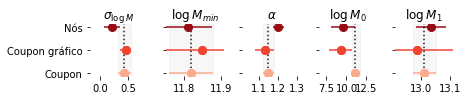

In [10]:
fig, axs = plt.subplots(1, 5, figsize=(6.6, 1.5), sharey=True)

titles = labels
for ax, xcol, title in zip(axs, df_marg_means.columns, titles):
    for x, xerr, y, c in zip(df_marg_means[xcol], df_marg_stds[xcol], df_marg_means["name"], cm.Reds(np.linspace(0.3, 0.9, len(df_marg_means)))):
        try:
            ax.errorbar(x, [y], marker="o", xerr=xerr, ms=8, color=c)
        except ValueError:
            ax.errorbar(x, [y], marker="o", xerr=np.array(xerr).reshape(2,-1), ms=8, color=c)
    ax.set_title(title)
    ax.set_xlabel(f"value")
    ax.grid(False, axis="x")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.axvline(df_marg_means.loc[0, xcol], ls="dotted", color="k", alpha=.9)
    try:
        ax.axvspan(df_marg_means.loc[0, xcol] - df_marg_stds.loc[0, xcol],
                   df_marg_means.loc[0, xcol] + df_marg_stds.loc[0, xcol], color="k", alpha=0.03)
    except AttributeError:
        ax.axvspan(df_marg_means.loc[0, xcol] - df_marg_stds.loc[0, xcol][0],
                   df_marg_means.loc[0, xcol] + df_marg_stds.loc[0, xcol][1], color="k", alpha=0.03)

    xmin = df_marg_means[xcol].min()
    xmax = df_marg_means[xcol].max()
    ax.set_xlim(xmin - (xmax - xmin) * 1.6, xmax + (xmax - xmin) * 1.6)
    ax.set_xlabel("")
fig.tight_layout()

fig.savefig(os.path.join(plot_dir, "constraints_comp_coupon_reproduction.pdf"), dpi=600)
fig.savefig(os.path.join(plot_dir, "constraints_comp_coupon_reproduction.png"), dpi=100)

In [11]:
acf_coupon_file                          = os.path.join(data_dir, "acf.dat")
theta_coupon, acf_coupon, acf_err_coupon = np.loadtxt(acf_coupon_file, unpack=True)

In [12]:
os.environ["HOD_PATH"] = os.path.abspath("../code/hod")
os.environ["HOD_DATA_PATH"] = os.path.abspath("../data/coupon-reproduction")
config_files_dir = os.path.join(data_dir, "cosmosis-files")
sample_files_dir = config_files_dir   # template for sample config files

In [13]:
def theoretical_acf_cosmosis(hodpars, angles=None, acf=None, cov=""):
    """
    Calculates theoretical acf for hod parameters hodpars.
    
    Parameters:
        hodpars: dict
            describes hod parameters. Should have the keys sigmaM, massMin, alpha, mass0, mass1, fcentral
        angles: np.ndarray
            array containing angles to calc acf on. Optional.
        acf: str
            path to acf file to mimic. Should be specified if angles is missing.
        cov: str
            path to covariance file to mimic. Optional
    
    Returns:
        angle, acf, acf_1h, acf_2h, ndensity
        
        angle: np.ndarray
            array with angles in degrees
        acf: np.ndarray
            array with calculated values for acf
        acf_1h: np.ndarray
            array with calculated values for 1 halo acf
        acf_2h: np.ndarray
            array with calculated values for 2 halo acf
        ndensity: float
            galaxy volumetric density for given hodpars
    """
        
    if acf is None:
        acf_temp = np.zeros_like(angles)
        acferr_temp = np.zeros_like(angles)
        np.savetxt(os.path.join(sample_files_dir, "acf_cosmosis.dat"), np.c_[angles, acf_temp, acferr_temp])
        acf = os.path.join(sample_files_dir, "acf_cosmosis.dat")

    override_dict = { 
        ("runtime", "sampler"): "test",
        ("hmc", "save_acf"): "T",
        ("sample_files", "acf"): acf,
        #("sample_files", "cov"): cov
    } 
    for key in hodpars:
        override_dict[("hod_parameters", key)] = str(hodpars[key])
        
    ini = Inifile(os.path.join(config_files_dir, "pipeline.ini"), override=override_dict)
    pipeline = LikelihoodPipeline(ini, override=override_dict)
    
    data = \
        pipeline.run_parameters(pipeline.parameters)
    
    ndensity = data["hod_parameters", "ndensity"]
    acf = data["acf_model", "acf"]
    acf_1h = data["acf_model", "acf_1h"]
    acf_2h = data["acf_model", "acf_2h"]
    angle = data["acf_model", "angle"]
    
    return angle, acf, acf_1h, acf_2h, ndensity

In [14]:
coupon_grafico_values["fcentral"] = 1.
coupon_values["fcentral"]         = 1.
bestfit["fcentral"]               = 1.

theta_bestfit, acf_bestfit, acf_1h_bestfit, acf_2h_bestfit, ndensity_bestfit = \
    theoretical_acf_cosmosis(bestfit, np.logspace(-3, np.log10(1.5), 100))

theta_model_coupon, acf_model_coupon, acf_model_1h_coupon, acf_model_2h_coupon, ndensity_coupon = \
    theoretical_acf_cosmosis(coupon_grafico_values, np.logspace(-3, np.log10(1.5), 100))

Reading included ini file: `/home/pedro/Documents/mestrado/monografia-analise/data/coupon-reproduction/cosmosis-files/cosmo.ini'
Reading included ini file: `/home/pedro/Documents/mestrado/monografia-analise/data/coupon-reproduction/cosmosis-files/sample_parameters.ini'
Reading included ini file: `/home/pedro/Documents/mestrado/monografia-analise/data/coupon-reproduction/cosmosis-files/sample_files.ini'
Reading included ini file: `/home/pedro/Documents/mestrado/monografia-analise/data/coupon-reproduction/cosmosis-files/cosmo.ini'
Reading included ini file: `/home/pedro/Documents/mestrado/monografia-analise/data/coupon-reproduction/cosmosis-files/sample_parameters.ini'

Parameter Priors
----------------
cosmological_parameters--w                    ~ delta(-1.0)
cosmological_parameters--omega_b              ~ delta(0.045)
cosmological_parameters--omega_m              ~ delta(0.25)
cosmological_parameters--omega_k              ~ delta(0.0)
cosmological_parameters--h0                   ~ d

In [15]:
bestfit_interp = interp1d(theta_bestfit, acf_bestfit)

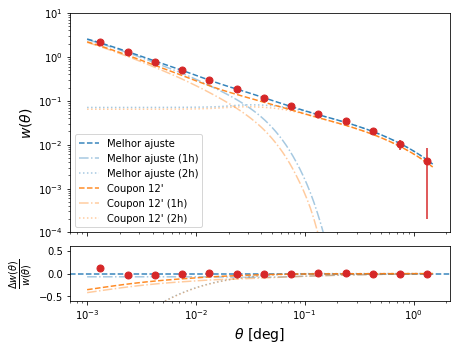

In [16]:
#fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

fig = plt.figure(figsize=(6.6, 5.0))

#gs = GridSpec(2, 1, height_ratios=[2.5, 1], hspace=0.25)
gs = GridSpec(2, 1, height_ratios=[4, 1], hspace=0.10)
ax2 = fig.add_subplot(gs[1])
ax1 = fig.add_subplot(gs[0], sharex=ax2)


ax = ax1
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim(1e-4, 1e1)
l = ax.plot(theta_bestfit, acf_bestfit, color="tab:blue", ls="dashed", alpha=0.9, label=r"Melhor ajuste")
l = l[0]
ax.plot(theta_bestfit, acf_1h_bestfit,
        color=l.get_color(), alpha=0.4, ls="dashdot", label=r"Melhor ajuste (1h)")
ax.plot(theta_bestfit, acf_2h_bestfit,
        color=l.get_color(), alpha=0.4, ls="dotted", label=r"Melhor ajuste (2h)")

l = ax.plot(theta_model_coupon, acf_model_coupon, ls="dashed", alpha=0.9, color="tab:orange", label=r"Coupon 12'")
l = l[0]
ax.plot(theta_model_coupon, acf_model_1h_coupon,
        color=l.get_color(), alpha=0.4, ls="dashdot", label=r"Coupon 12' (1h)")
ax.plot(theta_model_coupon, acf_model_2h_coupon,
        color=l.get_color(), alpha=0.4, ls="dotted", label=r"Coupon 12' (2h)")
ax.errorbar(theta_coupon, acf_coupon, acf_err_coupon, ls='', marker='o', color="tab:red", ms=7.)

ax.set_ylabel(r"$w(\theta)$", fontsize=14)
ax.legend(fontsize=10, loc="lower left")

ax  = ax2

ax.set_xscale("log")
#axs.set_yscale("log")
ax.set_ylim(-0.6, 0.6)

l = ax.axhline(0., ls="dashed", color="tab:blue", alpha=0.9)
ax.plot(theta_bestfit, acf_1h_bestfit - bestfit_interp(theta_bestfit),
        color=l.get_color(), alpha=0.4, ls="dashdot")
ax.plot(theta_bestfit, acf_2h_bestfit - bestfit_interp(theta_bestfit),
        color=l.get_color(), alpha=0.4, ls="dotted")

l = ax.plot(theta_model_coupon, acf_model_coupon - bestfit_interp(theta_model_coupon),
            ls="dashed", alpha=0.9, color="tab:orange")
l = l[0]
ax.plot(theta_model_coupon, acf_model_1h_coupon - bestfit_interp(theta_model_coupon),
        color=l.get_color(), alpha=0.4, ls="dashdot")
ax.plot(theta_model_coupon, acf_model_2h_coupon - bestfit_interp(theta_model_coupon),
        color=l.get_color(), alpha=0.4, ls="dotted")
ax.errorbar(theta_coupon, acf_coupon - bestfit_interp(theta_coupon), acf_err_coupon,
            ls='', marker="o", color="tab:red", ms=7.)

ax.set_xlabel(r"$\theta$ [deg]", fontsize=14)
#ax.set_ylabel(r"$\frac{w(\theta) - w_{melhor\: ajuste}(\theta)}{w_{melhor\: ajuste}(\theta)}$", fontsize=14);
ax.set_ylabel(r"$\frac{\Delta w(\theta)}{w(\theta)}$", fontsize=14);

plt.setp(ax1.get_xticklabels(), visible=False)
plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.15)

fig.savefig(os.path.join(plot_dir, "acf_comparison_coupon_reproduction.pdf"), dpi=600)
fig.savefig(os.path.join(plot_dir, "acf_comparison_coupon_reproduction.png"), dpi=100)

### Git tags (notebook)

In [17]:
%%bash

for dir in $(find ../code/ -mindepth 1 -maxdepth 1 -type d -printf "%P\n") ;
do
    pushd ../code/$dir > /dev/null
    echo "$dir: $(git rev-parse HEAD)"
    popd > /dev/null
done

pushd $COSMOSIS_SRC_DIR > /dev/null
echo "cosmosis: $(git rev-parse HEAD)"
pushd $COSMOSIS_SRC_DIR/cosmosis-standard-library > /dev/null
echo "cosmosis-standard-library: $(git rev-parse HEAD)"

__pycache__: 824126a38be8ff1b1ed95aab2fb79b59fb40bdec
hod: 5aae026793e6346e22dfde8a4c9889f805c07130
chain-diagnostics: 212f01c17b4226da0c35fe7e5314e17699f8cc94
jackknife-tools: 739c049f37c02820baa255ca11228538c2661291
halotools-utils: 6b22d1d9ea0a87413e46ecff90cea7065e3c6782
hod-scripting-utils: 9cb4ad2c97dc8a881bd9bf84d9392719d3bcaf45
cosmosis: 14abd2e9ae8d01d0623b223a1fc15babd69a2cd9
cosmosis: 14abd2e9ae8d01d0623b223a1fc15babd69a2cd9
cosmosis-standard-library: bbafc5af7de75f152526ef1e8213449a08956884


bash: /home/pedro/miniconda3/envs/monografia/lib/libtinfo.so.6: no version information available (required by bash)
